## Demo: Triggers in ParallelActivity
The basic steps to set up an OpenCLSim simulation are:
* Import libraries
* Initialise simpy environment
* Define object classes
* Create objects
  * Create sites
  * Create vessels
  * Create activities
* Register processes and run simpy

----

This notebook shows a single run consisting of the following four phases:
* sail empty
* loading
* sail full
* unloading

#### 0. Import libraries

In [1]:
import datetime, time
import simpy

import shapely.geometry
import pandas as pd

import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

#### 1. Initialise simpy environment

In [2]:
# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)

#### 2. Define object classes

In [3]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
        core.LoadingFunction,
        core.UnloadingFunction,
    ),
    {},
)

#### 3. Create objects
##### 3.1. Create site object(s)

In [4]:
# prepare input data for from_site
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
data_from_site = {"env": my_env,
                  "name": "from_site",
                  "geometry": location_from_site,
                  "capacity": 100,
                  "level": 50
                 }
# instantiate from_site 
from_site = Site(**data_from_site)

# prepare input data for to_site
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
data_to_site = {"env": my_env,
                "name": "to_site",
                "geometry": location_to_site,
                "capacity": 50,
                "level": 0
               }
# instantiate to_site 
to_site = Site(**data_to_site)

##### 3.2. Create vessel object(s)

In [5]:
# prepare input data for vessel_01
data_vessel01 = {"env": my_env,
                 "name": "vessel01",
                 "geometry": location_from_site, 
                 "loading_rate": 0.00001,
                 "unloading_rate": 0.00001,
                 "capacity": 4,
                 "compute_v": lambda x: 10
               }
# instantiate vessel_01 
vessel01 = TransportProcessingResource(**data_vessel01)

##### 3.3 Create activity/activities

In [6]:
# initialise registry
registry = {}

In [7]:
# create a list of the sub processes
sub_processes_main = [
    model.MoveActivity(
        env=my_env,
        name="sailing empty",
        registry=registry,
        mover=vessel01,
        destination=from_site,
        duration=1000,
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="Loading",
        registry=registry,
        processor=vessel01,
        origin=from_site,
        destination=vessel01,
        amount=4,
        duration=1000,
    ),
    model.MoveActivity(
        env=my_env,
        name="sailing filled",
        registry=registry,
        mover=vessel01,
        destination=to_site,
        duration=1000,
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="unloading",
        registry=registry,
        processor=vessel01,
        origin=vessel01,
        destination=to_site,
        amount=4,
        duration=1000,
        start_event=[
            {
                "name": "prepair",
                "type": "activity",
                "state": "done"
            }
        ]
    ),
    model.BasicActivity(
        env=my_env,
        name="Basic activity",
        registry=registry,
        duration=1000,
        additional_logs=[vessel01],
    ),
]

# create a 'sequential activity' that is made up of the 'sub_processes'
sequential_activity_main = model.SequentialActivity(
    env=my_env,
    name="main_process",
    registry=registry,
    sub_processes=sub_processes_main,
)

# create a list of the sub processes
sub_processes_helper = [
    model.BasicActivity(
        env=my_env,
        name="prepair",
        registry=registry,
        duration=10000,
        additional_logs=[vessel01],
    ),
    model.BasicActivity(
        env=my_env,
        name="clean-up",
        registry=registry,
        duration=1000,
        additional_logs=[vessel01],
        start_event=[
            {
                "name": "unloading",
                "type": "activity",
                "state": "done"
            }
        ]
    ),
]

# create a 'sequential activity' that is made up of the 'sub_processes'
sequential_activity_helper = model.SequentialActivity(
    env=my_env,
    name="helper_process",
    registry=registry,
    sub_processes=sub_processes_helper,
)

parallel = model.ParallelActivity(
    env=my_env,
    name="parallel",
    registry=registry,
    sub_processes=[sequential_activity_helper, sequential_activity_main],
)

while_activity = model.WhileActivity(
    env=my_env,
    name="while",
    registry=registry,
    sub_processes=[parallel],
    condition_event=[{"type": "container", "concept": to_site, "state": "full"}],
)

#### 4. Register processes and run simpy

In [8]:
model.register_processes([while_activity])
my_env.run()

#### 5. Inspect results
##### 5.1 Inspect logs

In [9]:
plot.get_log_dataframe(vessel01, [while_activity, *sub_processes_main, sequential_activity_main])

,Activity,Timestamp,ActivityState,geometry,container level,type,ref
0,ac924293-3cce-4273-8baf-05206a6c107a,1970-01-01 00:00:00,START,POINT (4.18055556 52.18664444),0.0,additional log,ac924293-3cce-4273-8baf-05206a6c107a
1,sailing empty,1970-01-01 00:00:00,START,POINT (4.18055556 52.18664444),0.0,NaN,NaN
2,sailing empty,1970-01-01 00:16:40,STOP,POINT (4.18055556 52.18664444),0.0,NaN,NaN
3,Loading,1970-01-01 00:16:40,START,POINT (4.18055556 52.18664444),0.0,NaN,NaN
4,Loading,1970-01-01 00:33:20,STOP,POINT (4.18055556 52.18664444),4.0,NaN,NaN
...,...,...,...,...,...,...,...
203,c821964e-7f14-44f2-a4da-3cf12f740c2d,1970-01-02 18:46:40,WAIT_START,POINT (4.25222222 52.11428333),0.0,additional log,c821964e-7f14-44f2-a4da-3cf12f740c2d
204,c821964e-7f14-44f2-a4da-3cf12f740c2d,1970-01-02 19:03:20,WAIT_STOP,POINT (4.25222222 52.11428333),0.0,additional log,c821964e-7f14-44f2-a4da-3cf12f740c2d
205,c821964e-7f14-44f2-a4da-3cf12f740c2d,1970-01-02 19:03:20,START,POINT (4.25222222 52.11428333),0.0,additional log,c821964e-7f14-44f2-a4da-3cf12f740c2d
206,Basic activity,1970-01-02 19:20:00,STOP,POINT (4.25222222 52.11428333),0.0,additional log,db466905-6ae9-417a-aaf5-413f85883a82


In [10]:
plot.get_log_dataframe(vessel01, [while_activity, *sub_processes_helper, sequential_activity_helper])

,Activity,Timestamp,ActivityState,geometry,container level,type,ref
0,prepair,1970-01-01 00:00:00,START,POINT (4.18055556 52.18664444),0.0,additional log,ac924293-3cce-4273-8baf-05206a6c107a
1,cbbf0dfb-ea86-43f1-b9b3-920659a75039,1970-01-01 00:00:00,START,POINT (4.18055556 52.18664444),0.0,NaN,NaN
2,cbbf0dfb-ea86-43f1-b9b3-920659a75039,1970-01-01 00:16:40,STOP,POINT (4.18055556 52.18664444),0.0,NaN,NaN
3,a6fc4d1f-8d0e-48f9-9b9d-7ac79e37cb0a,1970-01-01 00:16:40,START,POINT (4.18055556 52.18664444),0.0,NaN,NaN
4,a6fc4d1f-8d0e-48f9-9b9d-7ac79e37cb0a,1970-01-01 00:33:20,STOP,POINT (4.18055556 52.18664444),4.0,NaN,NaN
...,...,...,...,...,...,...,...
203,clean-up,1970-01-02 18:46:40,WAIT_START,POINT (4.25222222 52.11428333),0.0,additional log,c821964e-7f14-44f2-a4da-3cf12f740c2d
204,clean-up,1970-01-02 19:03:20,WAIT_STOP,POINT (4.25222222 52.11428333),0.0,additional log,c821964e-7f14-44f2-a4da-3cf12f740c2d
205,clean-up,1970-01-02 19:03:20,START,POINT (4.25222222 52.11428333),0.0,additional log,c821964e-7f14-44f2-a4da-3cf12f740c2d
206,db466905-6ae9-417a-aaf5-413f85883a82,1970-01-02 19:20:00,STOP,POINT (4.25222222 52.11428333),0.0,additional log,db466905-6ae9-417a-aaf5-413f85883a82


##### 5.2 Visualise gantt charts

In [11]:
 plot.get_gantt_chart([*sub_processes_helper, *sub_processes_main])

##### 5.3 Visualise step charts

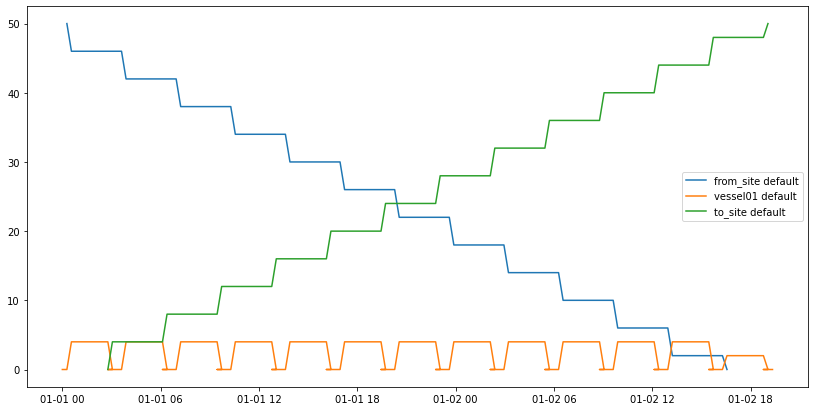

In [12]:
fig = plot.get_step_chart([from_site, vessel01, to_site])